# Scott Breitbach
## 24-Jan-2021
## DSC540, Weeks 7-8

In [1]:
import pandas as pd
import numpy as np
import pycountry

https://www.scq.ubc.ca/so-much-candy-data-seriously/

In [2]:
candy16url = "https://www.scq.ubc.ca/wp-content/uploads/2016/10/BOING-BOING-CANDY-HIERARCHY-2016-SURVEY-Responses.xlsx"
df = pd.read_excel(candy16url)

## Clean up Data:

### Remove any columns consisting entirely of NaNs:

In [3]:
for header in df.columns:
    if df[header].isnull().all() == True:
        df.drop(header, axis=1, inplace=True)
    else:
        continue

### Check for duplicates in each column:

In [4]:
print("Duplicates in:")
for name in df.columns:
    print("{:.<60}".format(name), any(df[name].duplicated()))

Duplicates in:
Timestamp................................................... False
Are you going actually going trick or treating yourself?.... True
Your gender:................................................ True
How old are you?............................................ True
Which country do you live in?............................... True
Which state, province, county do you live in?............... True
 [100 Grand Bar]............................................ True
 [Anonymous brown globs that come in black and orange wrappers] True
 [Any full-sized candy bar]................................. True
 [Black Jacks].............................................. True
 [Bonkers (the candy)]...................................... True
 [Bonkers (the board game)]................................. True
 [Bottle Caps].............................................. True
 [Box'o'Raisins]............................................ True
 [Broken glow stick].....................................

##### No duplicates in 'Timestamp', all other columns contain duplicates

### Check for columns without NaNs:

In [5]:
print("NaN's in:")
for name in df.columns:
    print("{:.<60} {}".format(name, df[name].isna().any()))

NaN's in:
Timestamp................................................... False
Are you going actually going trick or treating yourself?.... False
Your gender:................................................ True
How old are you?............................................ True
Which country do you live in?............................... True
Which state, province, county do you live in?............... True
 [100 Grand Bar]............................................ True
 [Anonymous brown globs that come in black and orange wrappers] True
 [Any full-sized candy bar]................................. True
 [Black Jacks].............................................. True
 [Bonkers (the candy)]...................................... True
 [Bonkers (the board game)]................................. True
 [Bottle Caps].............................................. True
 [Box'o'Raisins]............................................ True
 [Broken glow stick]........................................ 

##### No NaNs in 'Timestamp' or 'Are you going actually going trick or treating yourself?' columns. All others contain at least 1 NaN.

### Replace NaNs in candy columns with 'UNKNOWN', because survey said to "leave blank if you have no idea what the item is":

In [6]:
startCol = df.columns[6]
endCol = df.columns[105]
df.loc[:, startCol:endCol] = df.loc[:, startCol:endCol].fillna('UNKNOWN')

In [7]:
# df.tail()

### Create a smaller DF with just User and Candy info:

In [8]:
dfLite = df.loc[:, :df.columns[105]]

### Make column names easier to read:

In [9]:
oldCols = list(df.columns[0:6])
newCols = ['Timestamp', 'TrickOrTreat', 'Gender', 'Age', 'Country', 'Locale']
dictCols = dict(zip(oldCols, newCols))

In [10]:
dfLite.rename(columns=dictCols, inplace=True)

### Clean up Country names:

In [11]:
countryDF = dfLite[['Timestamp', 'Country']].copy()

In [12]:
countryDF.head()

,Timestamp,Country
0,2016-10-24 05:09:23.033,Canada
1,2016-10-24 05:09:54.798,usa
2,2016-10-24 05:13:06.734,US
3,2016-10-24 05:14:17.192,usa
4,2016-10-24 05:14:24.625,USA


In [13]:
countryDF.Country.unique()

array(['Canada', 'usa', 'US', 'USA', 'UK', 'United States of America',
       'uSA', 'Japan', 'united states', 'USA ', 'canada', 'United States',
       'us', 'france', 'USSA', 'United States of America ', 'U.S.A.',
       'A tropical island south of the equator', 'england', 'uk',
       'Switzerland', 'Murica', 'United Kingdom', 'Neverland', 'USA!',
       'this one',
       "USA (I think but it's an election year so who can really tell)",
       'Korea', 51, 'Usa', nan, 'U.S.', 'Us', 'America ', 'Units States',
       'belgium', 'croatia', 'United states', 'Portugal', 'England',
       'USA USA USA', 'the best one - usa', 'USA! USA! USA!', 47,
       'united states ', 'Cascadia', 'españa', 'u.s.',
       "there isn't one for old men", 'United States ', 'Panama',
       'one of the best ones', 'The Yoo Ess of Aaayyyyyy',
       'United Kindom', 'France', 'America', 'Australia', 'hungary',
       'united states of america', 'UK ', 'Austria', 'Somewhere',
       'New Zealand', 54, 'Germ

#### Remove punctuation
Also replace fields that start wtih 'us' or end with 'usa' with just 'usa'.  
This should cover most instances of repeated USA, or other variants.

In [14]:
countryDF['CountryCleaned'] = countryDF['Country'].str.lower().str.replace('[.,!]', '')
countryDF['CountryCleaned'] = np.where(countryDF['CountryCleaned'].str.startswith('us'), 
                                       'usa', countryDF['CountryCleaned'])
countryDF['CountryCleaned'] = np.where(countryDF['CountryCleaned'].str.endswith('usa'), 
                                       'usa', countryDF['CountryCleaned'])

In [15]:
countryDF.CountryCleaned = countryDF.CountryCleaned.str.strip()

#### Perform replacements for remaining oddballs:
Note: 'uk' changed to 'united kingdom' to avoid conversion to 'Ukraine'.

In [16]:
replacements = {
    'uk': 'united kingdom',
    'units states': 'usa',
    'america': 'usa',
    'the yoo ess of aaayyyyyy': 'usa',
    'españa': 'spain',
    'murica': 'usa',
    'united kindom': 'united kingdom',
    'brasil': 'brazil',
    "god's country": 'usa',
    'united sates': 'usa',
    "sub-canadian north america 'merica": 'usa',
    'trumpistan': 'usa',
    'united stetes': 'usa',
    'united  states of america': 'usa'
}

countryDF['CountryCleaned'].replace(replacements, inplace=True)

In [17]:
countryDF.CountryCleaned = countryDF.CountryCleaned.str.strip()

#### Perform Fuzzy Matching on Countries:

In [18]:
def fuzzyCountry(countryName):
    try:
        return pycountry.countries.search_fuzzy(countryName)[0].name
    except:
#         return ("NOT FOUND")  # for troubleshooting matching
        return(np.nan)

countryDF['FuzzyMatch'] = countryDF.apply(lambda row: fuzzyCountry(row.CountryCleaned), axis=1)

#### A couple more fixes:

In [19]:
countryDF.FuzzyMatch.replace("Korea, Democratic People's Republic of", "North Korea", inplace=True)

In [20]:
countryDF.FuzzyMatch.iloc[725] = 'South Korea'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
countryDF.FuzzyMatch.unique()

array(['Canada', 'United States', 'United Kingdom', 'Japan', 'France',
       nan, 'Switzerland', 'North Korea', 'Belgium', 'Croatia',
       'Portugal', 'Spain', 'Panama', 'Australia', 'Hungary', 'Austria',
       'New Zealand', 'Germany', 'Mexico', 'Brazil', 'South Korea',
       'Philippines', 'Tonga', 'Sweden', 'Netherlands', 'Finland',
       'American Samoa', 'China', 'Kenya'], dtype=object)

#### Perform a merge for non-null values:

In [22]:
countryDF['Combined'] = countryDF['FuzzyMatch'].combine_first(countryDF['Country'])

In [23]:
countryDF[countryDF['FuzzyMatch'].isnull()]

,Timestamp,Country,CountryCleaned,FuzzyMatch,Combined
57,2016-10-24 05:54:40.128,A tropical island south of the equator,a tropical island south of the equator,NaN,A tropical island south of the equator
89,2016-10-24 06:15:22.247,Neverland,neverland,NaN,Neverland
99,2016-10-24 06:21:18.515,this one,this one,NaN,this one
310,2016-10-24 08:50:32.535,Cascadia,cascadia,NaN,Cascadia
411,2016-10-24 10:21:01.946,there isn't one for old men,there isn't one for old men,NaN,there isn't one for old men
444,2016-10-24 11:00:42.575,one of the best ones,one of the best ones,NaN,one of the best ones
612,2016-10-24 14:48:10.100,Somewhere,somewhere,NaN,Somewhere
1071,2016-10-27 10:42:49.888,See above,see above,NaN,See above
1124,2016-10-27 12:23:56.227,The republic of Cascadia,the republic of cascadia,NaN,The republic of Cascadia
1156,2016-10-27 13:53:10.380,Not the USA or Canada,not the usa or canada,NaN,Not the USA or Canada


#### Merge back to dataset:

In [24]:
dfLite['Country'] = countryDF['FuzzyMatch']

In [25]:
dfLite.iloc[0:3, 0:6]

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
0,2016-10-24 05:09:23.033,No,Male,22,Canada,Ontario
1,2016-10-24 05:09:54.798,No,Male,45,United States,il
2,2016-10-24 05:13:06.734,No,Female,48,United States,Colorado


### Clean up Age column:

In [26]:
dfLite['Age'].unique()

array([22, 45, 48, 57, 42, 41, 47, 28, 44, 34, 46, 40, 31, 33, 35, 49, 16,
       60, 30, 51, 38, 54, 43, 50, 37, 55, 58, 32,
       'Old enough to know better ', 64, 61, 65, 26, 36, 78, 39, 52, 29,
       63, 'old enough',
       'As old as my tongue a few years older than my teeth', '50s',
       'old', nan, 10, 62, '0x2A', 23, 20, 24, 17, 27, 53, 18, 13, 56, 66,
       'Fifty.  Nine.  Ish.', 25, 59, 74, 19, 'Ancient',
       'I remember the Nixon administration', 'over retirement age', 14,
       79, 'Old enough', '50+', 70, '55+', 'over 40', 'Hahahahahaha', 68,
       81, 1000000000000000000, 'Old', 'Older than i act', 'really old',
       12, 67, 'blah', 23.2, 11, 'older than I want to be', 21, 71,
       'Not as old as you...', 82, 'Never ask a woman that question.',
       'old ', 'Same as yo mama', 15,
       'Too old to trick or treat without it being creepy', 'ancient',
       142, 7, 'Old enough to not Trick or Treat.', '49 11/12ths'],
      dtype=object)

##### Lots of weird ones here. Let's see what we can do.

In [27]:
dfAge = dfLite.copy()

#### Take a look at the non-numeric values:

In [28]:
dfAge['Age'][dfAge['Age'].str.isnumeric() == False]

57                             Old enough to know better 
99                                             old enough
100     As old as my tongue a few years older than my ...
102                                                   50s
104                                                   old
135                                                  0x2A
265                                   Fifty.  Nine.  Ish.
310                                               Ancient
415                   I remember the Nixon administration
423                                   over retirement age
444                                                   old
478                                            Old enough
495                                                   50+
512                                                   55+
516                                               over 40
524                                          Hahahahahaha
618                                            old enough
636           

#### Estimate ages given as text, rounding ranges down:

In [29]:
replacements = {
    '49 11/12ths': 49,
    '50+': 50,
    'over 40': 40,
    '55+': 55,
    'over retirement age': 65,
    'I remember the Nixon administration': 60, # estimated
    'Fifty.  Nine.  Ish.': 59,
    '0x2A': 42,  # in hexadecimal
    '50s': 50
}

dfAge['Age'].replace(replacements, inplace=True)

#### Replace remaining unknowns with null value:

In [30]:
dfAge[dfAge['Age'].str.isnumeric() == False] = np.nan

In [31]:
dfAge.Age.unique()

array([22, 45, 48, 57, 42, 41, 47, 28, 44, 34, 46, 40, 31, 33, 35, 49, 16,
       60, 30, 51, 38, 54, 43, 50, 37, 55, 58, 32, nan, 64, 61, 65, 26,
       36, 78, 39, 52, 29, 63, 10, 62, 23, 20, 24, 17, 27, 53, 18, 13, 56,
       66, 59, 25, 74, 19, 14, 79, 70, 68, 81, 1000000000000000000, 12,
       67, 23.2, 11, 21, 71, 82, 15, 142, 7], dtype=object)

#### Still some outliers.
Oldest person to ever live was 122; replace anything older with null:

In [32]:
dfAge[dfAge['Age'] > 122] = np.nan

#### Merge back to data set:

In [33]:
dfLite['Age'] = pd.to_numeric(dfAge['Age'])

## Heirarchical Index

In [34]:
dfIndexed = dfLite.copy()

#### Add TrickOrTreat, Gender, and Age indices:

In [35]:
indices = [dfIndexed.columns[1], dfIndexed.columns[2], dfIndexed.columns[3]]
dfIndexed.set_index(indices, inplace=True)

In [36]:
type(dfIndexed.index)

pandas.core.indexes.multi.MultiIndex

In [37]:
dfIndexed.head()

Timestamp        Country        Locale  \
TrickOrTreat Gender Age                                                         
No           Male   22.0 2016-10-24 05:09:23.033         Canada       Ontario   
                    45.0 2016-10-24 05:09:54.798  United States            il   
             Female 48.0 2016-10-24 05:13:06.734  United States      Colorado   
             Male   57.0 2016-10-24 05:14:17.192  United States            il   
Yes          Male   42.0 2016-10-24 05:14:24.625  United States  South Dakota   

                          [100 Grand Bar]  \
TrickOrTreat Gender Age                     
No           Male   22.0              JOY   
                    45.0              MEH   
             Female 48.0              JOY   
             Male   57.0              JOY   
Yes          Male   42.0              MEH   

                          [Anonymous brown globs that come in black and orange wrappers]  \
TrickOrTreat Gender Age                                                                    
No           Male   22.0                                            DESPAIR                
                    45.0                                                MEH                
             Female 48.0                                            DESPAIR                
             Male   57.0                                                MEH                
Yes          Male   42.0                                            DESPAIR                

                          [Any full-sized candy bar]  [Black Jacks]  \
TrickOrTreat Gender Age                                               
No           Male   22.0                         JOY            MEH   
                    45.0                         JOY            JOY   
             Female 48.0                         JOY            MEH   
             Male   57.0                         JOY            MEH   
Yes          Male   42.0                         JOY        DESPAIR   

                          [Bonkers (the candy)]  [Bonkers (the board game)]  \
TrickOrTreat Gender Age                                                       
No           Male   22.0                    MEH                         MEH   
                    45.0                DESPAIR                         MEH   
             Female 48.0                    MEH                         JOY   
             Male   57.0                    MEH                     DESPAIR   
Yes          Male   42.0                    MEH                         JOY   

                          [Bottle Caps]  ...  [Three Musketeers]  \
TrickOrTreat Gender Age                  ...                       
No           Male   22.0            MEH  ...                 JOY   
                    45.0            JOY  ...                 JOY   
             Female 48.0            JOY  ...                 JOY   
             Male   57.0        DESPAIR  ...                 JOY   
Yes          Male   42.0            MEH  ...                 JOY   

                          [Tolberone something or other]  [Trail Mix]  [Twix]  \
TrickOrTreat Gender Age                                                         
No           Male   22.0                             JOY      DESPAIR     JOY   
                    45.0                             JOY          MEH     JOY   
             Female 48.0                             JOY      DESPAIR     JOY   
             Male   57.0                             JOY          JOY     JOY   
Yes          Male   42.0                             JOY          MEH     JOY   

                          [Vials of pure high fructose corn syrup, for main-lining into your vein]  \
TrickOrTreat Gender Age                                                                              
No           Male   22.0                                            DESPAIR                          
                    45.0                                            DESPAIR                          
     

#### See what data we have for 40-year-old Males who go Trick-or-Treating:

In [38]:
dfIndexed.loc[('Yes', 'Male', 40)]

<ipython-input-38-22b2028c15bf>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  dfIndexed.loc[('Yes', 'Male', 40)]


Timestamp        Country    Locale  \
TrickOrTreat Gender Age                                                     
Yes          Male   40.0 2016-10-24 07:02:40.720  United States  Missouri   
                    40.0 2016-10-24 16:22:55.590  United States        CA   
                    40.0 2016-10-24 16:48:26.992  United States        ca   

                          [100 Grand Bar]  \
TrickOrTreat Gender Age                     
Yes          Male   40.0              JOY   
                    40.0              MEH   
                    40.0              JOY   

                          [Anonymous brown globs that come in black and orange wrappers]  \
TrickOrTreat Gender Age                                                                    
Yes          Male   40.0                                            DESPAIR                
                    40.0                                            DESPAIR                
                    40.0                                            DESPAIR                

                          [Any full-sized candy bar]  [Black Jacks]  \
TrickOrTreat Gender Age                                               
Yes          Male   40.0                         JOY        DESPAIR   
                    40.0                         JOY            MEH   
                    40.0                         JOY        DESPAIR   

                          [Bonkers (the candy)]  [Bonkers (the board game)]  \
TrickOrTreat Gender Age                                                       
Yes          Male   40.0                DESPAIR                         MEH   
                    40.0                    MEH                         MEH   
                    40.0                    MEH                         MEH   

                          [Bottle Caps]  ...  [Three Musketeers]  \
TrickOrTreat Gender Age                  ...                       
Yes          Male   40.0            MEH  ...                 JOY   
                    40.0        DESPAIR  ...                 MEH   
                    40.0            JOY  ...                 MEH   

                          [Tolberone something or other]  [Trail Mix]  [Twix]  \
TrickOrTreat Gender Age                                                         
Yes          Male   40.0                             JOY      DESPAIR     JOY   
                    40.0                             JOY      DESPAIR     MEH   
                    40.0                             MEH      DESPAIR     MEH   

                          [Vials of pure high fructose corn syrup, for main-lining into your vein]  \
TrickOrTreat Gender Age                                                                              
Yes          Male   40.0                                            DESPAIR                          
                    40.0                                            DESPAIR                          
                    40.0                                                MEH                          

                          [Vicodin]  [Whatchamacallit Bars]  [White Bread]  \
TrickOrTreat Gender Age                                                      
Yes          Male   40.0        JOY                     MEH        DESPAIR   
                    40.0        MEH                 DESPAIR        DESPAIR   
                    40.0        MEH                     JOY        DESPAIR   

                          [Whole Wheat anything]  [York Peppermint Patties]  
TrickOrTreat Gender Age                                                      
Yes          Male   40.0                 DESPAIR                        MEH  
                    40.0                 DESPAIR                    DESPAIR  
                    40.0                 DESPAIR                        MEH  

[3 rows x 103 columns]

## Pivot Tables

In [39]:
pivotDF = dfLite.copy()

#### Get average age of trick or treaters:

In [40]:
pd.pivot_table(pivotDF, index='TrickOrTreat')

,Age
TrickOrTreat,
No,40.875772
Yes,39.346154


#### Get average age of trick or treaters by gender:

In [41]:
pd.pivot_table(pivotDF, index='TrickOrTreat', columns='Gender')

Age                                       
Gender           Female I'd rather not say       Male    Other
TrickOrTreat                                                  
No            38.726496            36.9375  42.343906  31.0625
Yes           35.681818            46.5000  40.783133  67.0000

<AxesSubplot:xlabel='TrickOrTreat'>

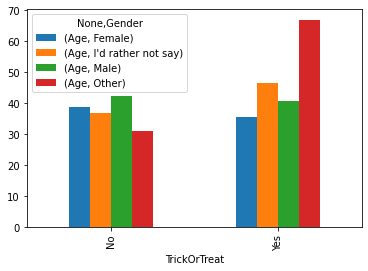

In [42]:
pd.pivot_table(pivotDF, index='TrickOrTreat', columns='Gender').plot(kind='bar')

#### Replace JOY, DESPAIR, MEH, and UNKNOWN with numerical values to get an overall sentiment.
JOY = 1  
DESPAIR = -1  
MEH, UNKNOWN = 0

In [43]:
pivotDF.replace('JOY', 1, inplace=True)
pivotDF.replace('DESPAIR', -1, inplace=True)
pivotDF.replace(['MEH', 'UNKNOWN'], 0, inplace=True)

In [44]:
pivotDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],...,[Three Musketeers],[Tolberone something or other],[Trail Mix],[Twix],"[Vials of pure high fructose corn syrup, for main-lining into your vein]",[Vicodin],[Whatchamacallit Bars],[White Bread],[Whole Wheat anything],[York Peppermint Patties]
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,1,-1,1,0,...,1,1,-1,1,-1,1,-1,-1,-1,1
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,0,0,1,1,...,1,1,0,1,-1,1,1,-1,-1,1
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,1,-1,1,0,...,1,1,-1,1,-1,-1,0,-1,-1,1


#### Get candy sentiment of Trick or Treaters vs non-Trick or Treaters:

In [45]:
pd.pivot_table(pivotDF, columns='TrickOrTreat', values=list(pivotDF.columns[6:]))

TrickOrTreat,No,Yes
[100 Grand Bar],0.371097,0.369565
[Anonymous brown globs that come in black and orange wrappers],-0.606601,-0.608696
[Any full-sized candy bar],0.822480,0.833333
[Black Jacks],-0.344335,-0.369565
[Blue M&M's],0.436218,0.434783
...,...,...
[Vicodin],0.046387,0.043478
[Whatchamacallit Bars],0.240856,0.253623
[White Bread],-0.764496,-0.688406
[Whole Wheat anything],-0.603925,-0.637681


#### Get candy sentiment by Gender:

In [46]:
pd.pivot_table(pivotDF, columns='Gender', values=list(pivotDF.columns[6:]))

Gender,Female,I'd rather not say,Male,Other
[100 Grand Bar],0.265854,0.321429,0.422642,0.470588
[Anonymous brown globs that come in black and orange wrappers],-0.629268,-0.428571,-0.601258,-0.529412
[Any full-sized candy bar],0.824390,0.642857,0.827673,0.941176
[Black Jacks],-0.363415,-0.214286,-0.343396,-0.235294
[Blue M&M's],0.439024,0.321429,0.440252,0.352941
...,...,...,...,...
[Vicodin],-0.068293,0.035714,0.101887,0.176471
[Whatchamacallit Bars],0.136585,0.107143,0.301887,0.176471
[White Bread],-0.712195,-0.607143,-0.787421,-0.647059
[Whole Wheat anything],-0.546341,-0.500000,-0.645283,-0.470588


## Groupby

In [47]:
groupDF = pivotDF.copy()

In [48]:
groupDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],...,[Three Musketeers],[Tolberone something or other],[Trail Mix],[Twix],"[Vials of pure high fructose corn syrup, for main-lining into your vein]",[Vicodin],[Whatchamacallit Bars],[White Bread],[Whole Wheat anything],[York Peppermint Patties]
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,1,-1,1,0,...,1,1,-1,1,-1,1,-1,-1,-1,1
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,0,0,1,1,...,1,1,0,1,-1,1,1,-1,-1,1
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,1,-1,1,0,...,1,1,-1,1,-1,-1,0,-1,-1,1


#### Group average candy sentiment by Trick or Treater, Yes or No:

In [49]:
groupDF[list(groupDF.columns[6:])].groupby(groupDF.TrickOrTreat).mean()

,[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],[Bonkers (the candy)],[Bonkers (the board game)],[Bottle Caps],[Box'o'Raisins],[Broken glow stick],[Butterfinger],...,[Three Musketeers],[Tolberone something or other],[Trail Mix],[Twix],"[Vials of pure high fructose corn syrup, for main-lining into your vein]",[Vicodin],[Whatchamacallit Bars],[White Bread],[Whole Wheat anything],[York Peppermint Patties]
TrickOrTreat,,,,,,,,,,,,,,,,,,,,,
No,0.371097,-0.606601,0.822480,-0.344335,-0.213202,-0.178412,-0.081178,-0.520071,-0.860839,0.510259,...,0.446922,0.644960,-0.225691,0.662801,-0.512043,0.046387,0.240856,-0.764496,-0.603925,0.453167
Yes,0.369565,-0.608696,0.833333,-0.369565,-0.159420,-0.057971,0.144928,-0.500000,-0.833333,0.514493,...,0.434783,0.572464,-0.260870,0.695652,-0.405797,0.043478,0.253623,-0.688406,-0.637681,0.384058


#### Group candy sentiment by Trick or Treat *and* Gender:

In [50]:
groupDF[list(groupDF.columns[6:])].groupby([groupDF.TrickOrTreat, groupDF.Gender]).mean()

[100 Grand Bar]  \
TrickOrTreat Gender                                 
No           Female                      0.265753   
             I'd rather not say          0.360000   
             Male                        0.418670   
             Other                       0.562500   
Yes          Female                      0.266667   
             I'd rather not say          0.000000   
             Male                        0.454545   
             Other                      -1.000000   

                                  [Anonymous brown globs that come in black and orange wrappers]  \
TrickOrTreat Gender                                                                                
No           Female                                                      -0.624658                 
             I'd rather not say                                          -0.480000                 
             Male                                                        -0.599717                 
             Other                                                       -0.625000                 
Yes          Female                                                      -0.666667                 
             I'd rather not say                                           0.000000                 
             Male                                                        -0.613636                 
             Other                                                        1.000000                 

                                  [Any full-sized candy bar]   [Black Jacks]  \
TrickOrTreat Gender                                                            
No           Female                                 0.819178       -0.372603   
             I'd rather not say                     0.720000       -0.240000   
             Male                                   0.826025       -0.332390   
             Other                                  0.937500       -0.250000   
Yes          Female                                 0.866667       -0.288889   
             I'd rather not say                     0.000000        0.000000   
             Male                                   0.840909       -0.431818   
             Other                                  1.000000        0.000000   

                                  [Bonkers (the candy)]  \
TrickOrTreat Gender                                       
No           Female                           -0.257534   
             I'd rather not say               -0.160000   
             Male                             -0.195191   
             Other                            -0.062500   
Yes          Female                           -0.222222   
             I'd rather not say                0.000000   
             Male                             -0.136364   
             Other                             0.000000   

                                  [Bonkers (the board game)]   [Bottle Caps]  \
TrickOrTreat Gender                                                            
No           Female                                -0.123288       -0.139726   
             I'd rather not say                    -0.120000        0.160000   
             Male                                  -0.212164       -0.060820   
             Other                                  0.000000        0.000000   
Yes          Female                                -0.044444        0.066667   
             I'd rather not say                     0.333333        0.666667   
             Male                                  -0.090909        0.181818   
             Other                                  1.000000       -1.000000   

                                  [Box'o'Raisins]   [Broken glow stick]  \
TrickOrTreat Gender                                                       
No           Female                     -0.484932             -0.873973   
             I'd rather not say         -0.480000             -0.840000   
         

#### Get total number of responses for each Country:

In [51]:
groupDF.groupby(groupDF.Country).size()

Country
American Samoa       2
Australia            4
Austria              1
Belgium              1
Brazil               1
Canada             118
China                1
Croatia              1
Finland              1
France               3
Germany              5
Hungary              1
Japan                4
Kenya                1
Mexico               3
Netherlands          3
New Zealand          4
North Korea          1
Panama               1
Philippines          1
Portugal             1
South Korea          1
Spain                1
Sweden               1
Switzerland          1
Tonga                1
United Kingdom      21
United States     1064
dtype: int64

### Group with Functions

#### Group by Gender and Trick or Treating; get some summary stats:

In [52]:
grouped = groupDF.groupby(['TrickOrTreat', 'Gender'])
functions = ['count', 'min', 'max', 'mean', 'std']
grouped['Age'].agg(functions)

count   min   max       mean        std
TrickOrTreat Gender                                                     
No           Female                351  10.0  82.0  38.726496  11.351494
             I'd rather not say     16  26.0  50.0  36.937500   7.388899
             Male                  681  16.0  79.0  42.343906  10.459579
             Other                  16  17.0  54.0  31.062500  10.089392
Yes          Female                 44   7.0  62.0  35.681818  13.559126
             I'd rather not say      2  15.0  78.0  46.500000  44.547727
             Male                   83  16.0  63.0  40.783133   8.809707
             Other                   1  67.0  67.0  67.000000        NaN

## Datetime

In [53]:
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

In [54]:
timeDF = pivotDF.iloc[:, :6].copy()

In [55]:
timeDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado


In [56]:
timeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     1259 non-null   datetime64[ns]
 1   TrickOrTreat  1259 non-null   object        
 2   Gender        1250 non-null   object        
 3   Age           1199 non-null   float64       
 4   Country       1248 non-null   object        
 5   Locale        1180 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 59.1+ KB


##### Timestamp column appears to contain datetime / Timestamp data

In [57]:
type(timeDF['Timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

#### Convert Timestamp to string:

In [58]:
tempDF = timeDF.copy()

In [59]:
tempDF['TimeToString'] = tempDF.Timestamp.astype(str)

In [60]:
tempDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,TimeToString
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,2016-10-24 05:09:23.033
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,2016-10-24 05:09:54.798
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,2016-10-24 05:13:06.734


In [61]:
type(tempDF.TimeToString[0])

str

#### Convert string to datetime:

In [62]:
tempDF['StrToDatetime'] = pd.to_datetime(tempDF.TimeToString)

In [63]:
tempDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,TimeToString,StrToDatetime
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,2016-10-24 05:09:23.033,2016-10-24 05:09:23.033
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,2016-10-24 05:09:54.798,2016-10-24 05:09:54.798
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,2016-10-24 05:13:06.734,2016-10-24 05:13:06.734


In [64]:
type(tempDF.StrToDatetime[0])

pandas._libs.tslibs.timestamps.Timestamp

In [65]:
tempDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Timestamp      1259 non-null   datetime64[ns]
 1   TrickOrTreat   1259 non-null   object        
 2   Gender         1250 non-null   object        
 3   Age            1199 non-null   float64       
 4   Country        1248 non-null   object        
 5   Locale         1180 non-null   object        
 6   TimeToString   1259 non-null   object        
 7   StrToDatetime  1259 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 78.8+ KB


### Set Timestamp to index:

In [66]:
timeDF.index = timeDF.Timestamp

In [67]:
timeDF.head()

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
Timestamp,,,,,,
2016-10-24 05:09:23.033,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario
2016-10-24 05:09:54.798,2016-10-24 05:09:54.798,No,Male,45.0,United States,il
2016-10-24 05:13:06.734,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado
2016-10-24 05:14:17.192,2016-10-24 05:14:17.192,No,Male,57.0,United States,il
2016-10-24 05:14:24.625,2016-10-24 05:14:24.625,Yes,Male,42.0,United States,South Dakota


### Filter data from October 25, 2016:

In [68]:
oct25DF = timeDF.loc['2016-10-25']

In [69]:
oct25DF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
Timestamp,,,,,,
2016-10-25 00:08:16.476,2016-10-25 00:08:16.476,No,Male,32.0,United States,new york
2016-10-25 00:23:59.019,2016-10-25 00:23:59.019,No,Female,57.0,United States,Oregon
2016-10-25 00:24:28.753,2016-10-25 00:24:28.753,No,Male,46.0,United States,tx


In [70]:
oct25DF.tail(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
Timestamp,,,,,,
2016-10-25 21:31:47.121,2016-10-25 21:31:47.121,No,Male,47.0,Canada,British Columbia
2016-10-25 22:37:10.222,2016-10-25 22:37:10.222,No,Male,45.0,United States,Oregon
2016-10-25 23:49:58.685,2016-10-25 23:49:58.685,No,Male,28.0,United States,California


### Generate date range:

In [71]:
dateRange = pd.date_range(timeDF['Timestamp'].min(), periods=20, freq='H')
dateRange

DatetimeIndex(['2016-10-24 05:09:23.033000', '2016-10-24 06:09:23.033000',
               '2016-10-24 07:09:23.033000', '2016-10-24 08:09:23.033000',
               '2016-10-24 09:09:23.033000', '2016-10-24 10:09:23.033000',
               '2016-10-24 11:09:23.033000', '2016-10-24 12:09:23.033000',
               '2016-10-24 13:09:23.033000', '2016-10-24 14:09:23.033000',
               '2016-10-24 15:09:23.033000', '2016-10-24 16:09:23.033000',
               '2016-10-24 17:09:23.033000', '2016-10-24 18:09:23.033000',
               '2016-10-24 19:09:23.033000', '2016-10-24 20:09:23.033000',
               '2016-10-24 21:09:23.033000', '2016-10-24 22:09:23.033000',
               '2016-10-24 23:09:23.033000', '2016-10-25 00:09:23.033000'],
              dtype='datetime64[ns]', freq='H')

### Shifting Dates; Offsets

In [72]:
timeDF.Timestamp.shift(2).head()

Timestamp
2016-10-24 05:09:23.033                       NaT
2016-10-24 05:09:54.798                       NaT
2016-10-24 05:13:06.734   2016-10-24 05:09:23.033
2016-10-24 05:14:17.192   2016-10-24 05:09:54.798
2016-10-24 05:14:24.625   2016-10-24 05:13:06.734
Name: Timestamp, dtype: datetime64[ns]

In [73]:
from pandas.tseries.offsets import Day

In [74]:
offset = Day()
timeDF.Age.groupby(offset.rollforward).mean().head()

2016-10-24 05:09:23.033    22.0
2016-10-24 05:09:54.798    45.0
2016-10-24 05:13:06.734    48.0
2016-10-24 05:14:17.192    57.0
2016-10-24 05:14:24.625    42.0
Name: Age, dtype: float64

### Resampling with Periods
#### Get average Age by Day of Timestamp:

In [75]:
timeDF.resample('D').mean()

,Age
Timestamp,
2016-10-24,41.036461
2016-10-25,38.678082
2016-10-26,41.096774
2016-10-27,41.258333
2016-10-28,36.346154
2016-10-29,43.571429
2016-10-30,41.666667


In [80]:
dfLite.to_csv('candy_cleaned.csv', index=False)